In [3]:
import scanpy as sc
from scperturb import edist, pairwise_pca_distances, equal_subsampling
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from tqdm import tqdm
from muon import prot as pt
import matplotlib
import math

from sklearn.metrics import pairwise_distances
from statsmodels.stats.multitest import multipletests

import h5py 

from scipy.stats import zscore
from scipy.cluster.hierarchy import distance, linkage, dendrogram
from scipy.cluster import hierarchy

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300



/Users/tessa/miniforge3/envs/pertpy-mf/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tessa/miniforge3/envs/pertpy-mf/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tessa/miniforge3/envs/pertpy-mf/lib/python3.9/site-packag

In [5]:
def cluster_matrix(matrix, how='row', return_order=False, method='centroid'):
    '''
    Hierarchical clustering of a matrix/dataframe. `how` can be 'col', 'row' or 'both' (default: 'row').
    '''
    if how not in ['col', 'row', 'both']:
        raise ValueError('Value for "how" must be row or col.')
    if how!='both':
        M = matrix if how=='row' else matrix.T
        dist = distance.pdist(M)
        link = linkage(dist, method=method)
        dend = dendrogram(link, no_plot=True)
        order = np.array(dend['leaves'], dtype=int)
        if return_order:
            return order
        elif isinstance(matrix, pd.DataFrame):
            return matrix.iloc[order] if how=='row' else matrix.iloc[:, order]
        else:
            return matrix[order] if how=='row' else matrix[:, order]
    else:
        if return_order:
            warn('Returning order when clustering both row and col is not supported.')
        matrix_ = cluster_matrix(matrix, how='row', return_order=False, method=method)
        return cluster_matrix(matrix_, how='col', return_order=False, method=method)
    


In [6]:

rna = sc.read_h5ad("/Users/tessa/Dropbox (HMS)/perturb_resource_tessa/pbmc/rna_only.h5ad")


protein = sc.read_h5ad("/Users/tessa/Dropbox (HMS)/perturb_resource_tessa/pbmc/protein_only.h5ad")


In [7]:
f = h5py.File("/Users/tessa/Dropbox (HMS)/perturb_resource_tessa/pbmc/pbmc_multimodal.h5seurat", 'r')
umap = f["reductions"]['umap']['cell.embeddings'][:,:]
cellids = f['cell.names'][:]
umap = pd.DataFrame(np.transpose(umap), index = cellids)
umap.index = umap.index.astype('str')

In [8]:
rna.obsm['X_umap'] = umap.values

In [9]:
rna = rna[(rna.obs['celltype.l2'] != "Eryth") & (rna.obs['celltype.l2'] != "ASDC" ),:]



/Users/tessa/miniforge3/envs/pertpy-mf/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


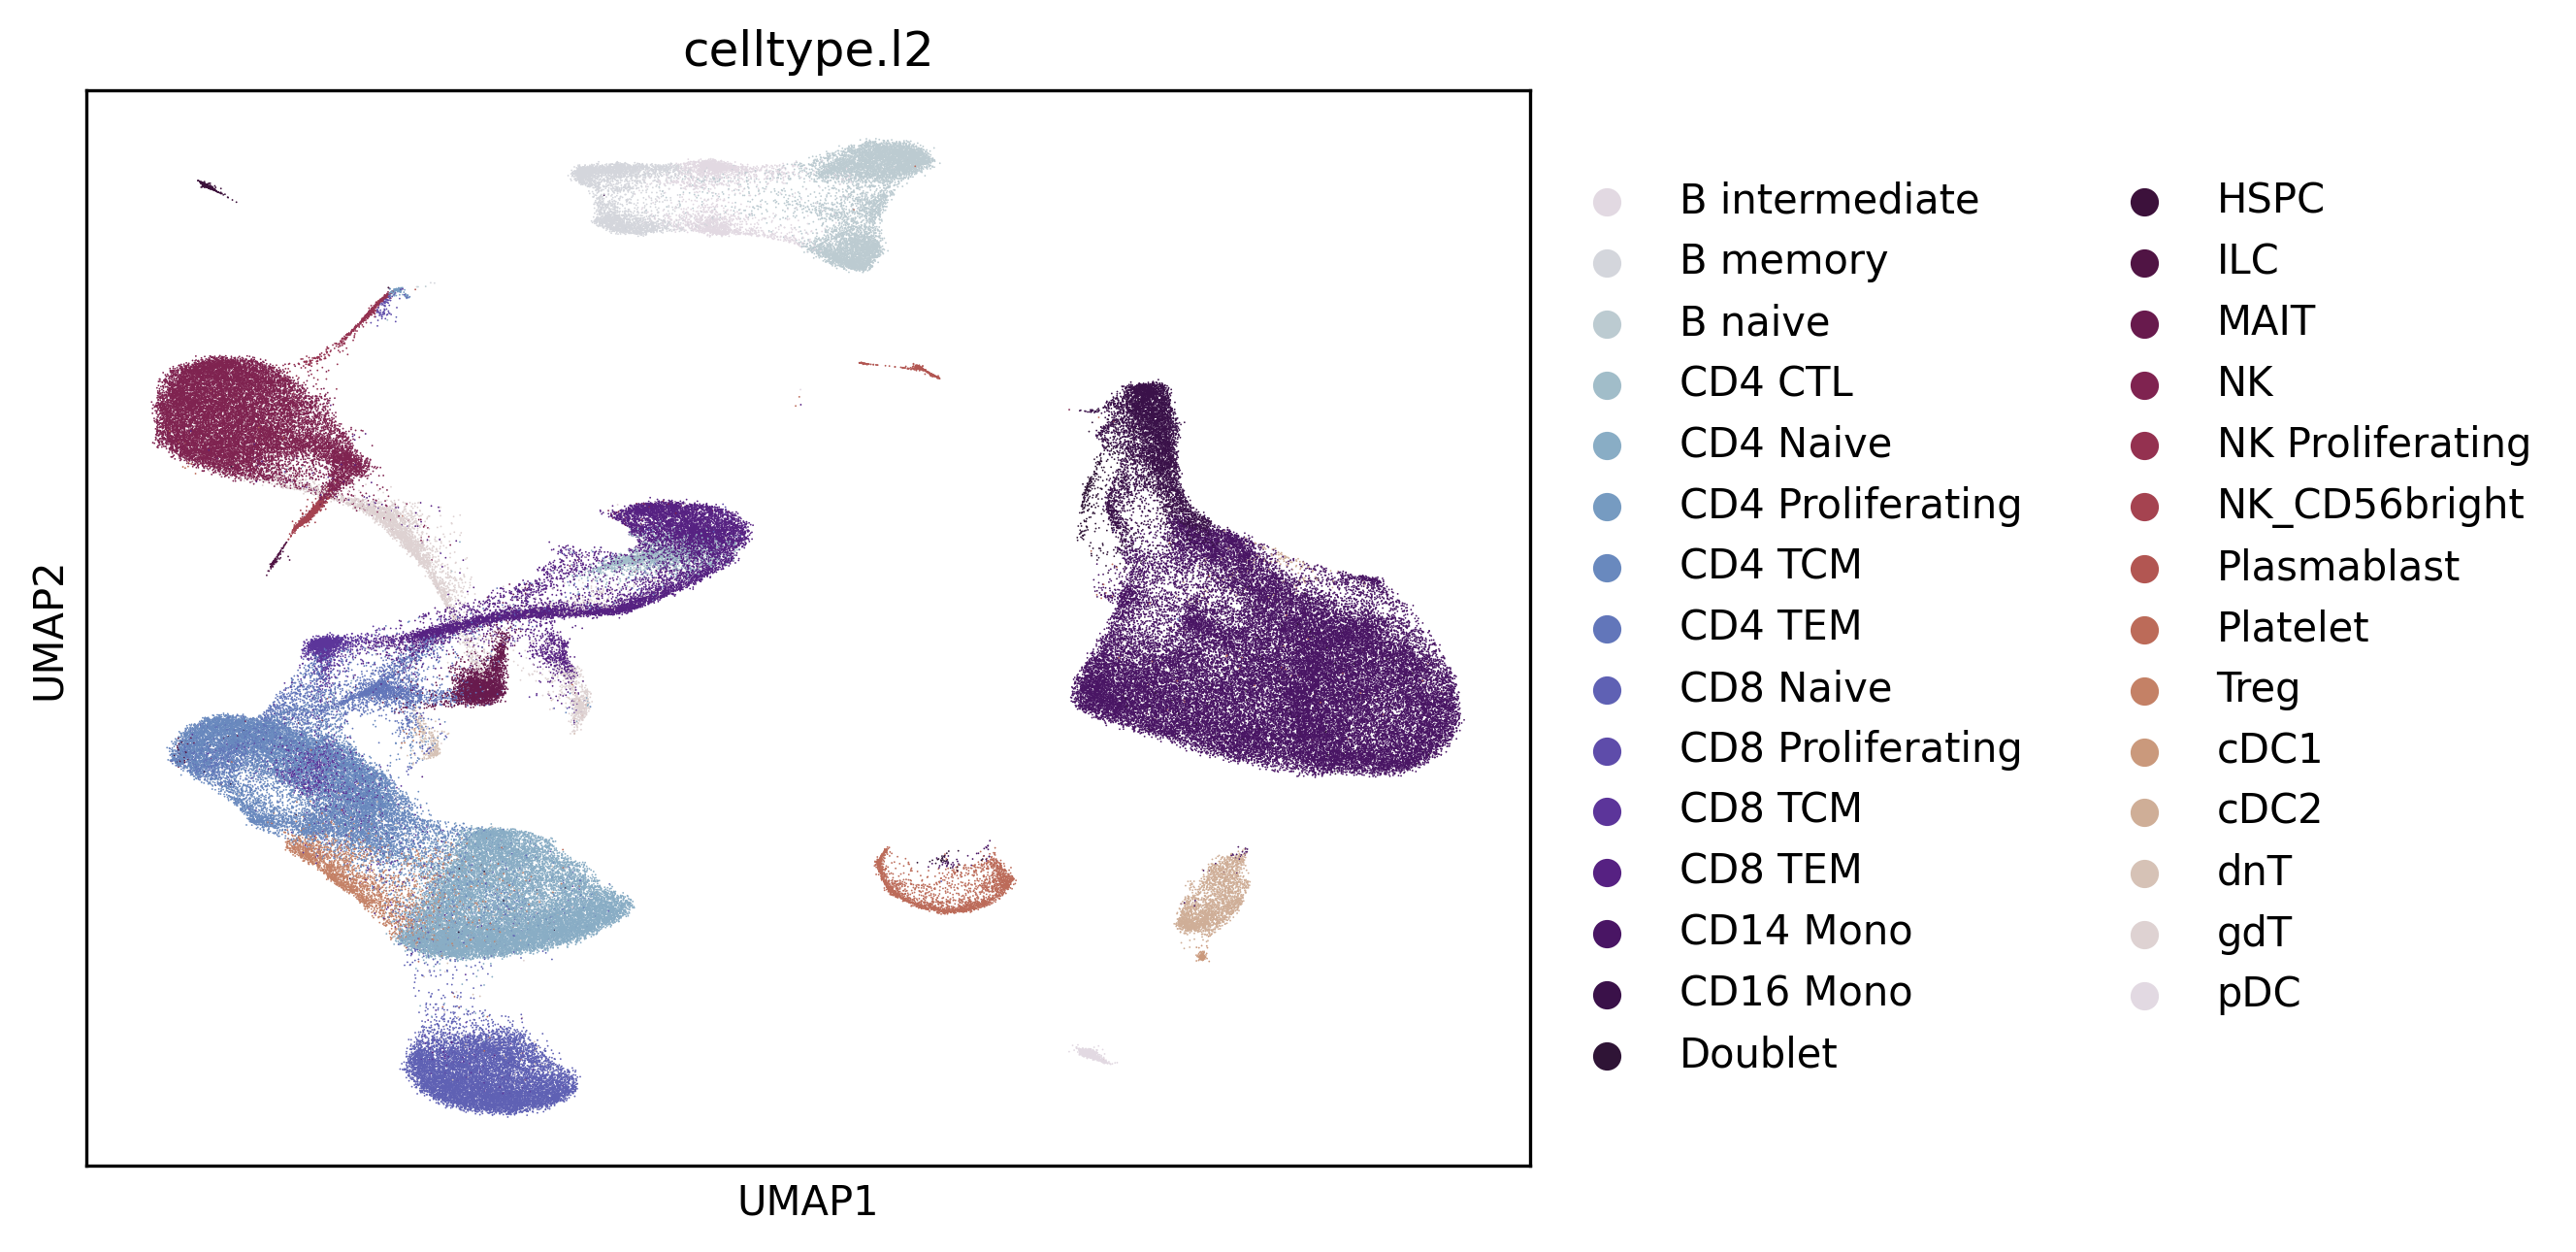

In [10]:
sc.pl.umap(rna, color = "celltype.l2", palette = 'twilight', save = "_full")

In [9]:
rna.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT',
       'nFeature_ADT', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2',
       'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'],
      dtype='object')

In [10]:
celltypes = rna.obs['celltype.l2'].unique()

In [11]:
# create a list of adata objects, one for each donor
donors = rna.obs['donor'].unique()
adata_list = []
for donor in donors:
    adata_list.append(rna[rna.obs['donor'] == donor,:].copy())

In [12]:
def process_adata(adata):
    adata.layers['counts'] = adata.X.copy()

    # basic qc and pp
    sc.pp.filter_cells(adata, min_counts=1000)
    sc.pp.normalize_per_cell(adata)
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

    n_var_max = 2000  # max total features to select
    sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
    sc.pp.log1p(adata)

    sc.pp.pca(adata, use_highly_variable=True)
    sc.pp.neighbors(adata)

    adata.uns['processed'] = True
    return(adata)

In [13]:
for i in range(len(adata_list)):
    adata_list[i] = process_adata(adata_list[i])



In [16]:
adata_list[0]

AnnData object with n_obs × n_vars = 17186 × 13591
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'n_counts'
    var: 'features', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'celltype.l2_colors', 'hvg', 'log1p', 'pca', 'neighbors', 'processed'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [17]:
estats = []
for adata in adata_list:
    # compute the PCA distances
    pwd_rna = pairwise_pca_distances(adata, 'celltype.l2', obsm_key='X_pca', dist='sqeuclidean', verbose=True)
    estats_rna = edist(adata, obs_key='celltype.l2', obsm_key='X_pca', pwd=pwd_rna, dist='sqeuclidean')
    estats.append(estats_rna)



  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:04<00:00,  6.04it/s]


In [29]:
# re-order the columns and rows of every entry in estats so that all match
estats[0] = cluster_matrix(estats[0], how='both', return_order=False, method='centroid')
for i in range(len(estats)):
    estats[i] = estats[i].loc[estats[0].index, estats[0].columns]

In [32]:
# make a matrix of correlations between all pairs of dataframes in estats
corr_matrix = np.zeros((len(estats), len(estats)))
for i in range(len(estats)):
    for j in range(len(estats)):
        corr_matrix[i,j] = estats[i].corrwith(estats[j], axis=1).mean()

In [33]:
corr_matrix

array([[1.        , 0.95570075, 0.96883919, 0.96909564, 0.96553075,
        0.97645307, 0.97697109, 0.97534675],
       [0.95570075, 1.        , 0.98253148, 0.97438896, 0.95865845,
        0.95090529, 0.95931425, 0.94940883],
       [0.96883919, 0.98253148, 1.        , 0.98059558, 0.96405038,
        0.95832861, 0.96548614, 0.96031027],
       [0.96909564, 0.97438896, 0.98059558, 1.        , 0.97202792,
        0.96267682, 0.98404481, 0.97478723],
       [0.96553075, 0.95865845, 0.96405038, 0.97202792, 1.        ,
        0.96878358, 0.98388318, 0.97734653],
       [0.97645307, 0.95090529, 0.95832861, 0.96267682, 0.96878358,
        1.        , 0.9815078 , 0.97661039],
       [0.97697109, 0.95931425, 0.96548614, 0.98404481, 0.98388318,
        0.9815078 , 1.        , 0.98209142],
       [0.97534675, 0.94940883, 0.96031027, 0.97478723, 0.97734653,
        0.97661039, 0.98209142, 1.        ]])

Text(0.5, 1.0, 'Correlation of pairwise distance matrices between donors')

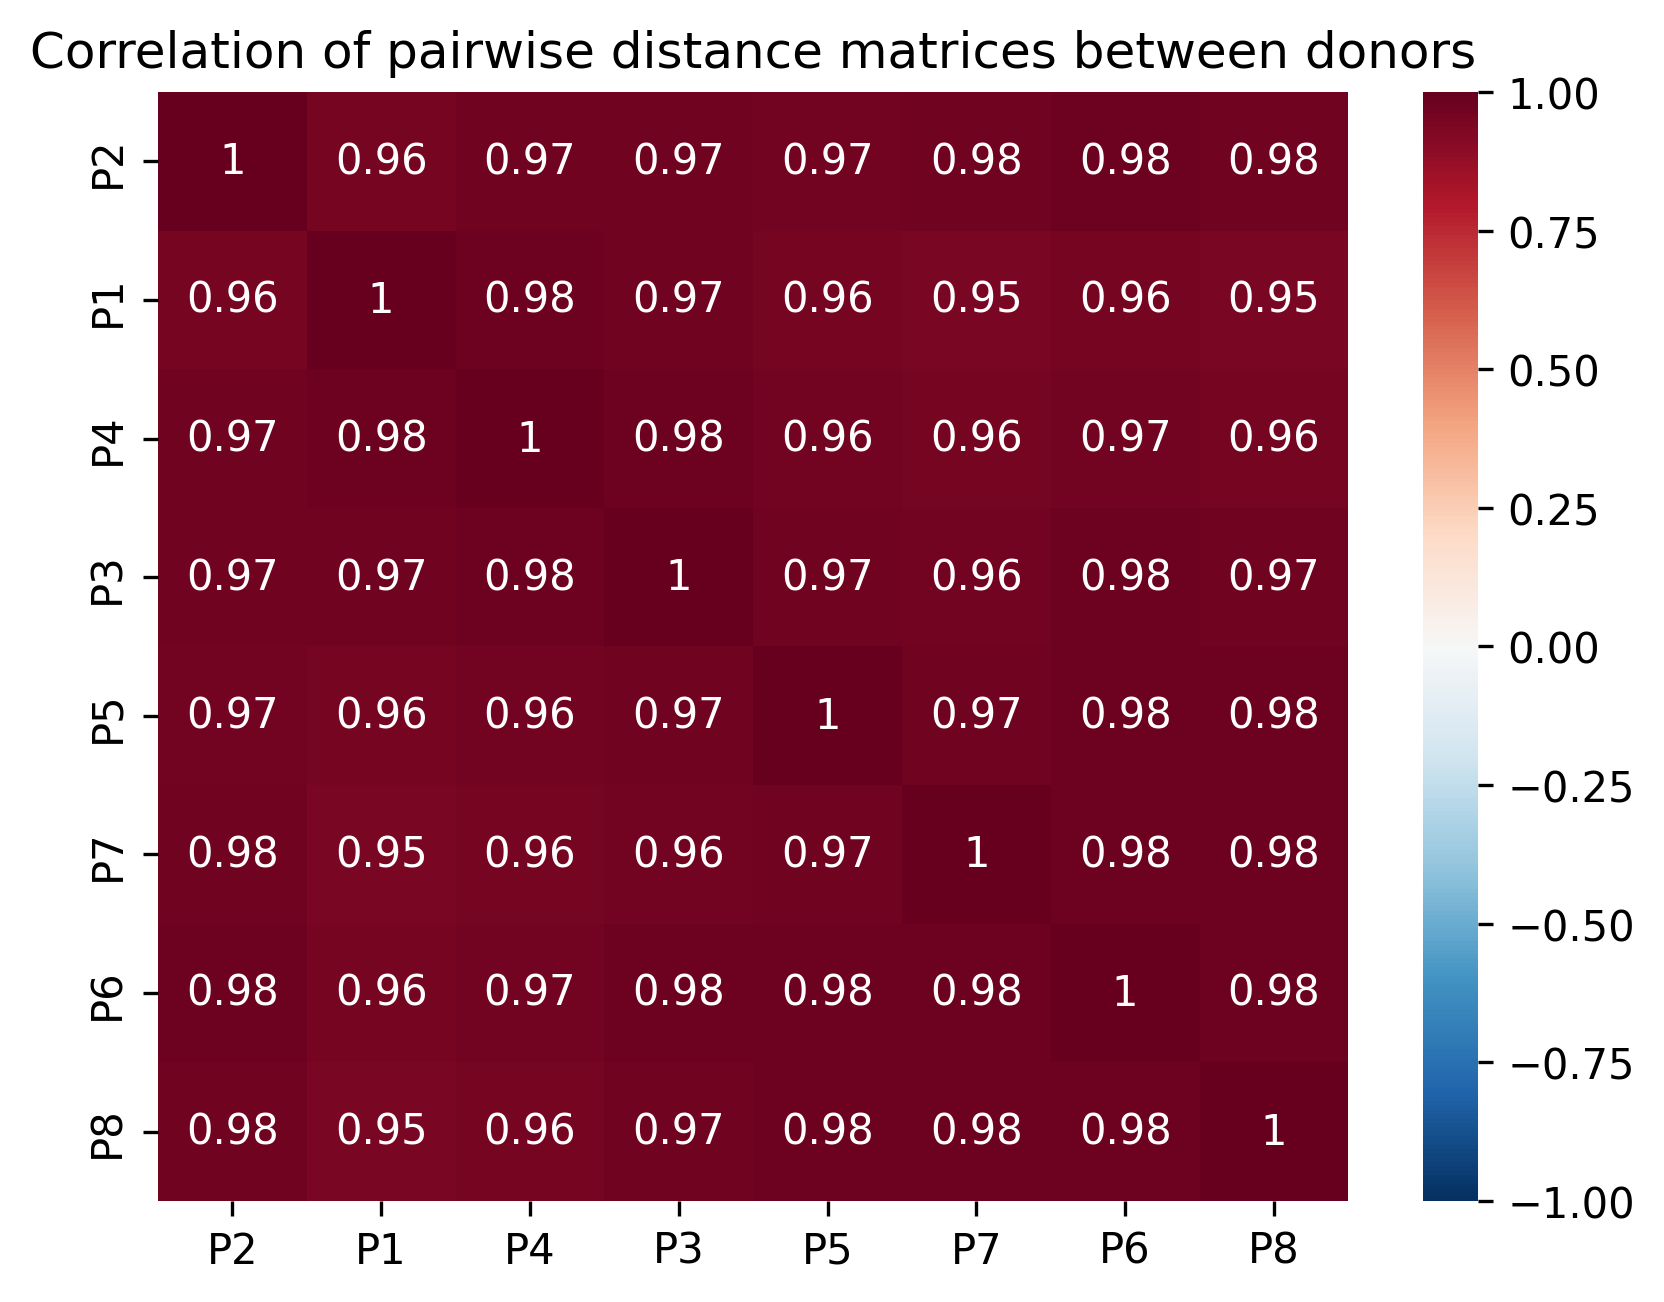

In [46]:
# plot a heatmap of corr_matrix
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', vmin=-1, vmax=1, xticklabels=donors, yticklabels=donors)
plt.title("Correlation of pairwise distance matrices between donors")

In [47]:
adata = equal_subsampling(rna, obs_key="celltype.l2", N_min=91)

In [48]:
adata.layers['counts'] = adata.X.copy()

# basic qc and pp
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.normalize_per_cell(adata)
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

n_var_max = 2000  # max total features to select
sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
sc.pp.log1p(adata)

sc.pp.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata)

adata.uns['processed'] = True

/Users/tessa/miniforge3/envs/pertpy-mf/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


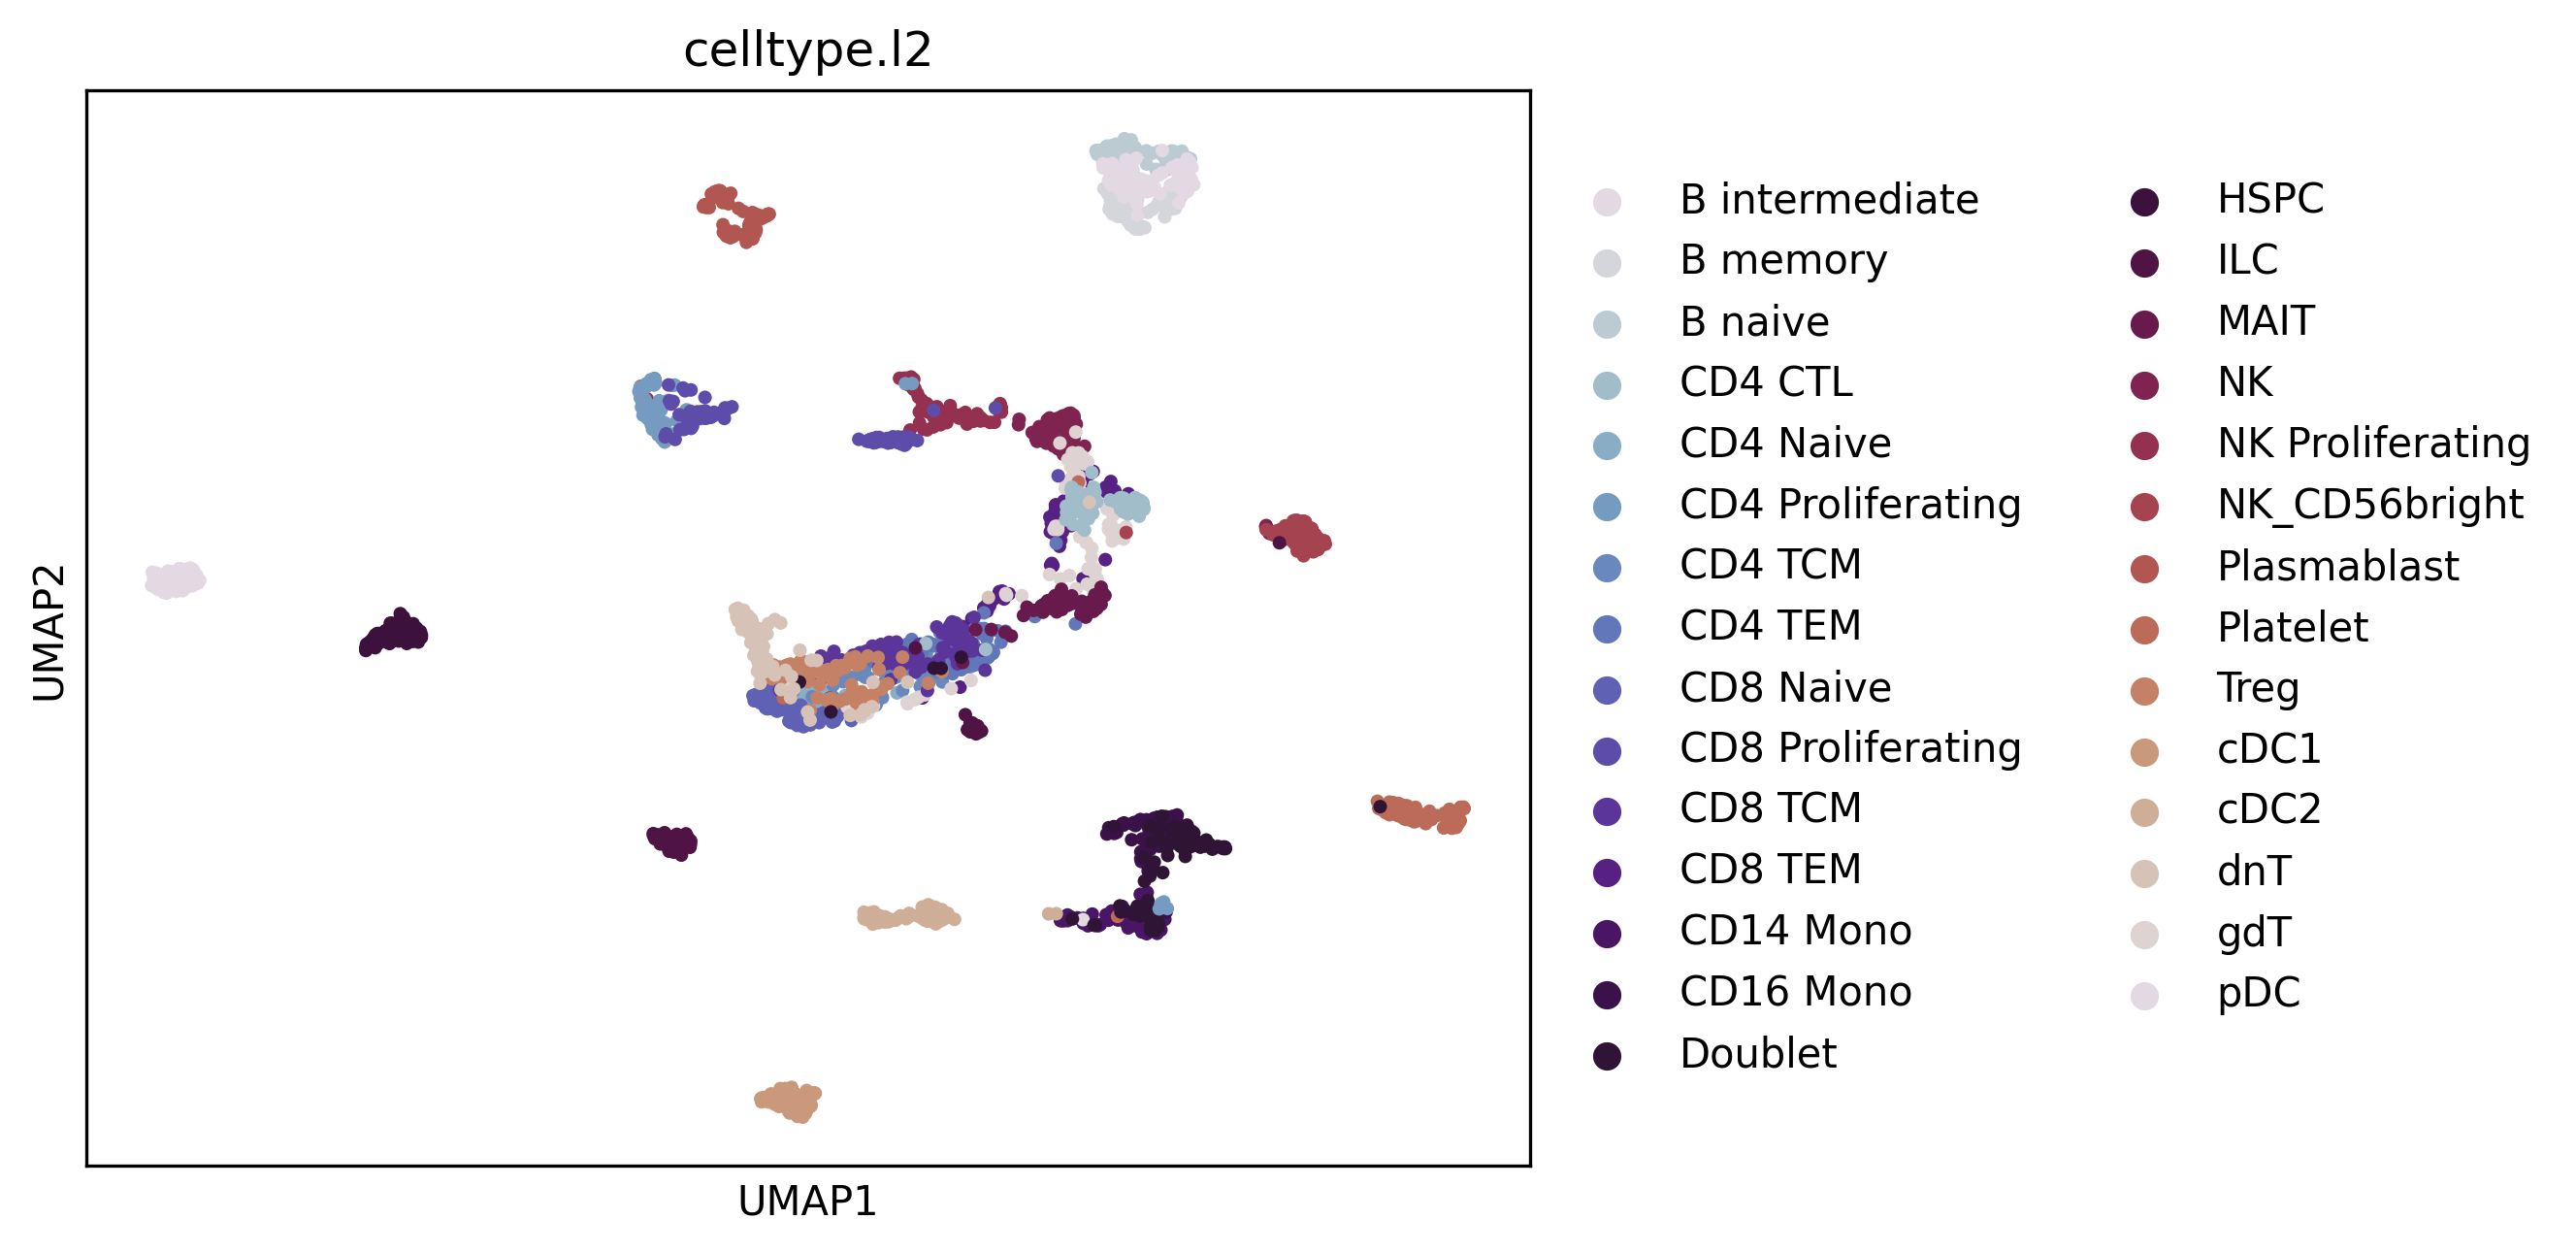

In [49]:
# redo the UMAP with the new PCA
sc.tl.umap(adata, min_dist=0.3, spread=2, random_state=42)
sc.pl.umap(adata, color=['celltype.l2'], palette = 'twilight', save = "_subset")

In [50]:
adata.obs['celltype'] = adata.obs['celltype.l2']
adata = adata[adata.obs['celltype']!="Doublet",:]


In [51]:
pwd_rna = pairwise_pca_distances(adata, 'celltype', obsm_key='X_pca', dist='sqeuclidean', verbose=True)


100%|██████████| 28/28 [00:00<00:00, 201.20it/s]


CategoricalIndex(['Platelet', 'CD14 Mono', 'Doublet', 'CD16 Mono', 'pDC',
                  'cDC2', 'cDC1', 'Plasmablast', 'B naive', 'B intermediate',
                  'B memory', 'HSPC', 'ILC', 'Treg', 'CD4 Naive', 'CD8 Naive',
                  'CD8 TCM', 'CD4 TEM', 'CD4 TCM', 'dnT', 'NK_CD56bright',
                  'MAIT', 'CD8 TEM', 'CD4 CTL', 'gdT', 'CD4 Proliferating',
                  'CD8 Proliferating', 'NK', 'NK Proliferating'],
                 categories=['B intermediate', 'B memory', 'B naive', 'CD4 CTL', ..., 'cDC2', 'dnT', 'gdT', 'pDC'], ordered=False, dtype='category', name='celltype.l2')

In [52]:
estats_rna = edist(adata, obs_key='celltype', obsm_key='X_pca', pwd=pwd_rna, dist='sqeuclidean')

In [58]:
# re-order the rows and columns of each entry in estats to match estats_rna
for i in range(len(estats)):
    estats[i] = estats[i].loc[estats_rna.index, estats_rna.columns]

#estats_rna = estats_rna.loc[estats[0].index, estats[0].columns]

/var/folders/_j/9fb8r7hn7zx13rt7glsw4j3h0000gn/T/ipykernel_58923/4294160403.py:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(ed, 'single')


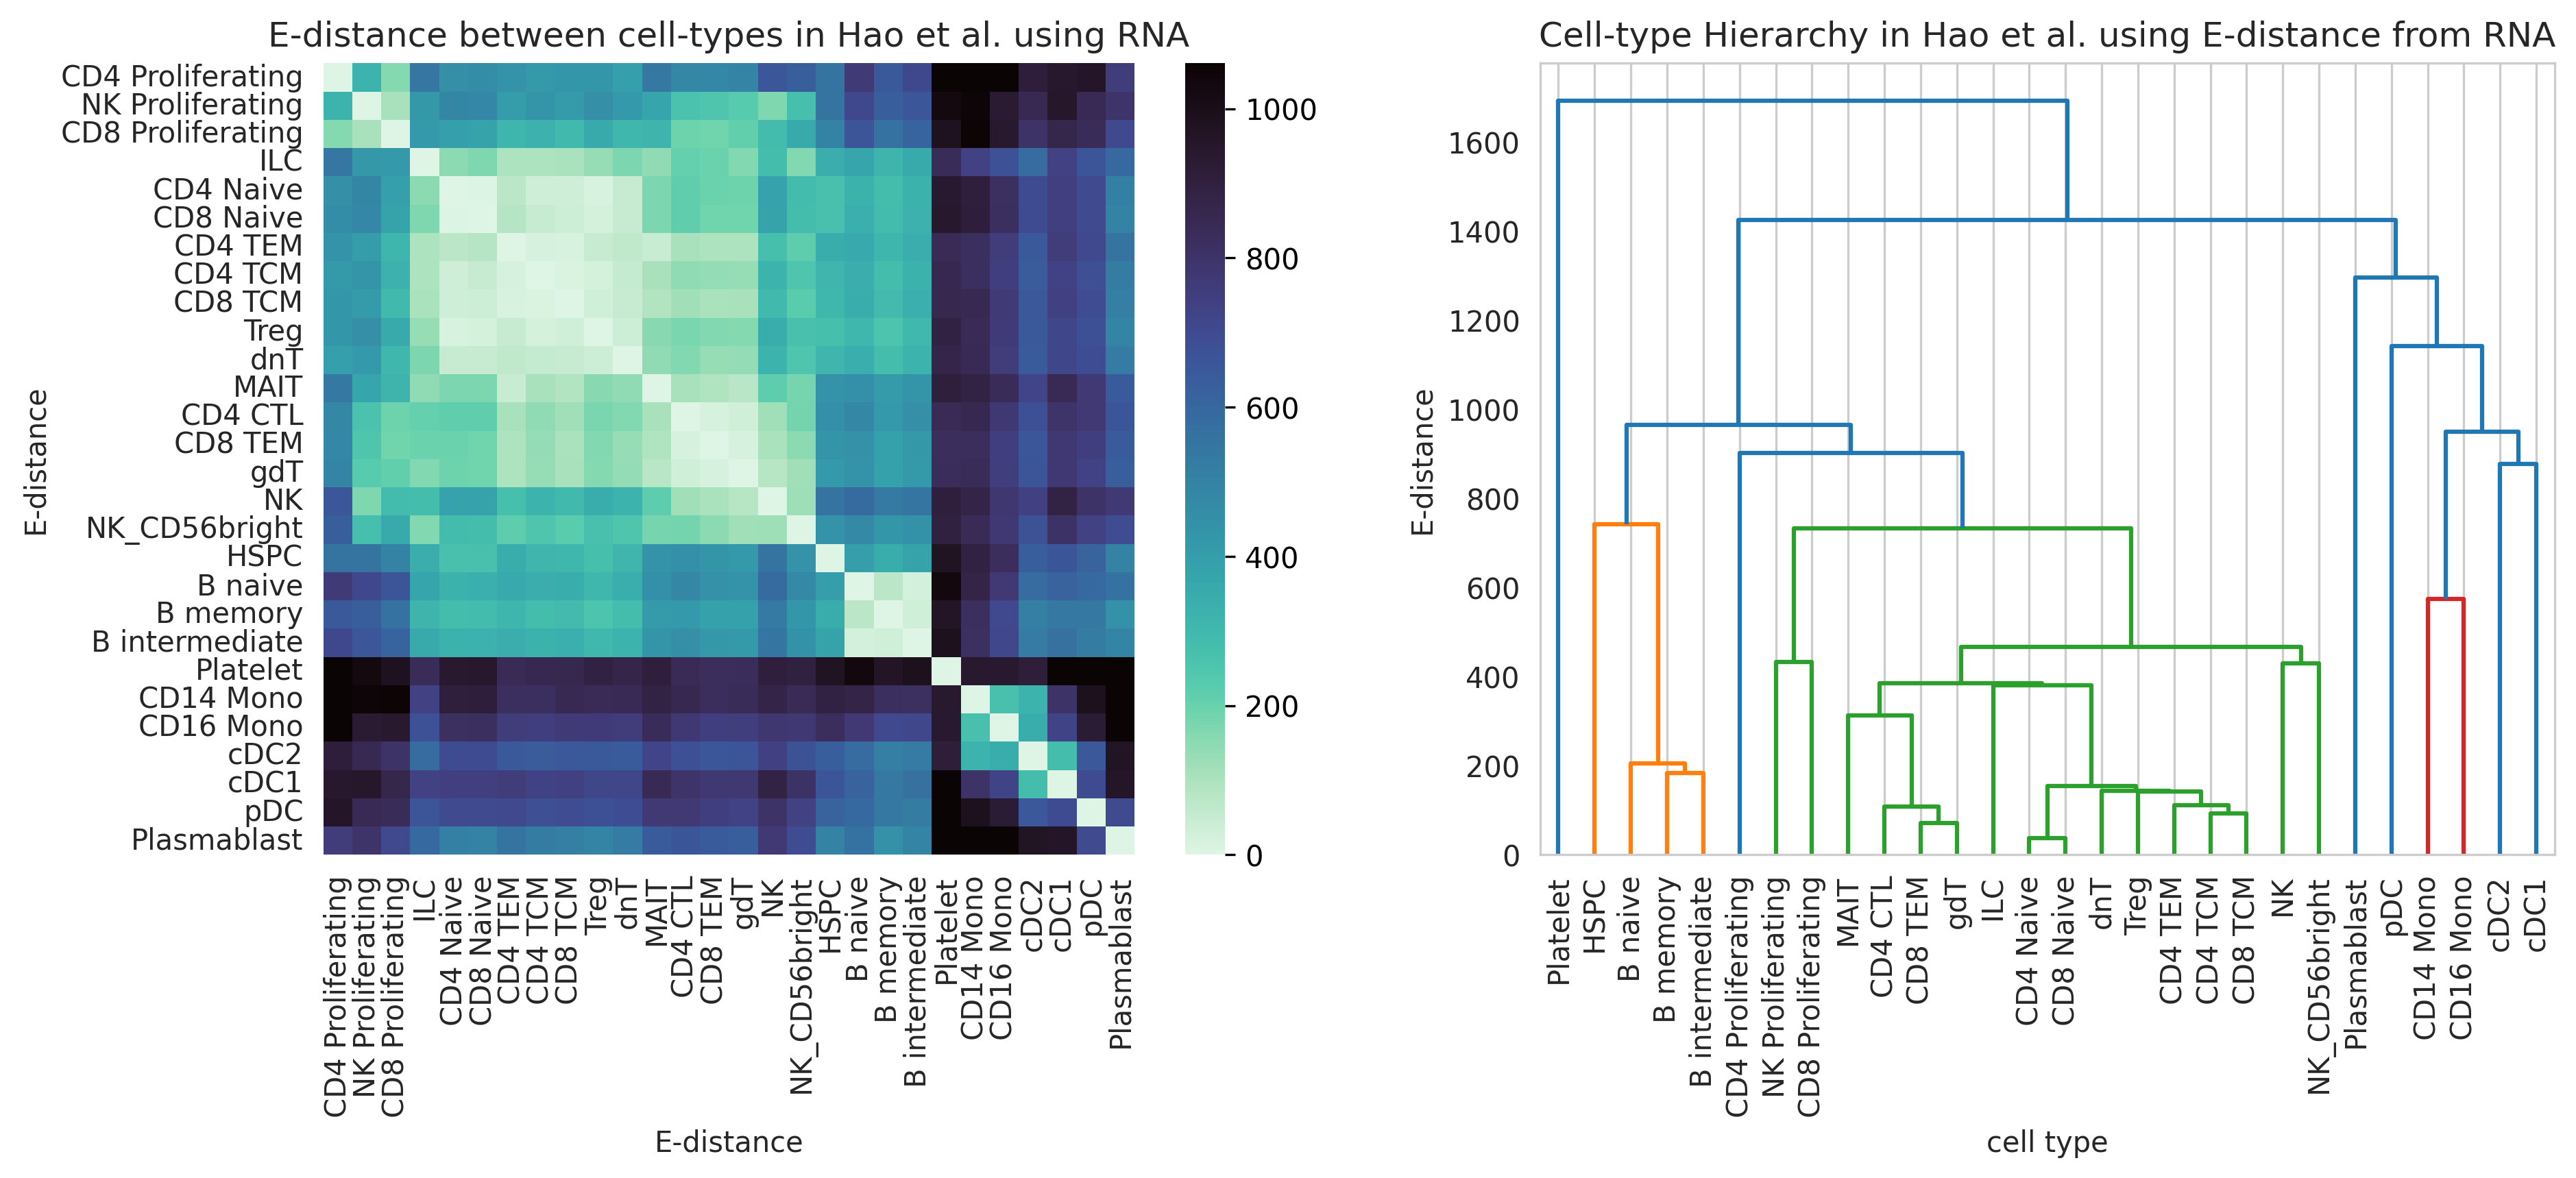

In [40]:

ed=estats_rna
with sns.axes_style('whitegrid'):
    fig, axs = plt.subplots(1, 2, figsize=[7*2,5])

ax = axs[0]
sns.heatmap(cluster_matrix(ed, "both"), robust=True, cmap = sns.cm.mako_r, xticklabels=True, yticklabels=True, ax=ax)
ax.set_title('E-distance between cell-types in Hao et al. using RNA')
ax.set_xlabel('E-distance')
ax.set_ylabel('E-distance')

ax=axs[1]
Z = hierarchy.linkage(ed, 'single')
dn = hierarchy.dendrogram(Z, labels=ed.columns, color_threshold=800, ax=ax)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.ylabel('E-distance')
plt.xlabel('cell type')
plt.title('Cell-type Hierarchy in Hao et al. using E-distance from RNA')
#plt.show()
plt.savefig("pbmc_RNA_HaoHao.pdf",bbox_inches="tight")

In [43]:
protein = sc.read_h5ad("/Users/tessa/Dropbox (HMS)/perturb_resource_tessa/pbmc/protein_only.h5ad")

In [44]:
protein = protein[protein.obs_names.isin(adata.obs_names),:]
pt.pp.clr(protein)
sc.pp.log1p(protein)
sc.pp.pca(protein)

/opt/anaconda3/envs/scvi/lib/python3.9/site-packages/muon/_prot/preproc.py:214: UserWarning: adata.X is sparse but not in CSC format. Converting to CSC.
  warn("adata.X is sparse but not in CSC format. Converting to CSC.")
/opt/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:373: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


In [45]:

protein.obs['celltype'] = protein.obs['celltype.l2']
protein = protein[protein.obs['celltype']!="Doublet",:]

pwd_prot = pairwise_pca_distances(protein, 'celltype', obsm_key='X_pca', dist='sqeuclidean', verbose=True)


100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 68.14it/s]


In [46]:
estats_prot = edist(protein, obs_key='celltype', obsm_key='X_pca', pwd=pwd_prot, dist='sqeuclidean')


/var/folders/_j/9fb8r7hn7zx13rt7glsw4j3h0000gn/T/ipykernel_14553/1560121542.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(ed, 'single')


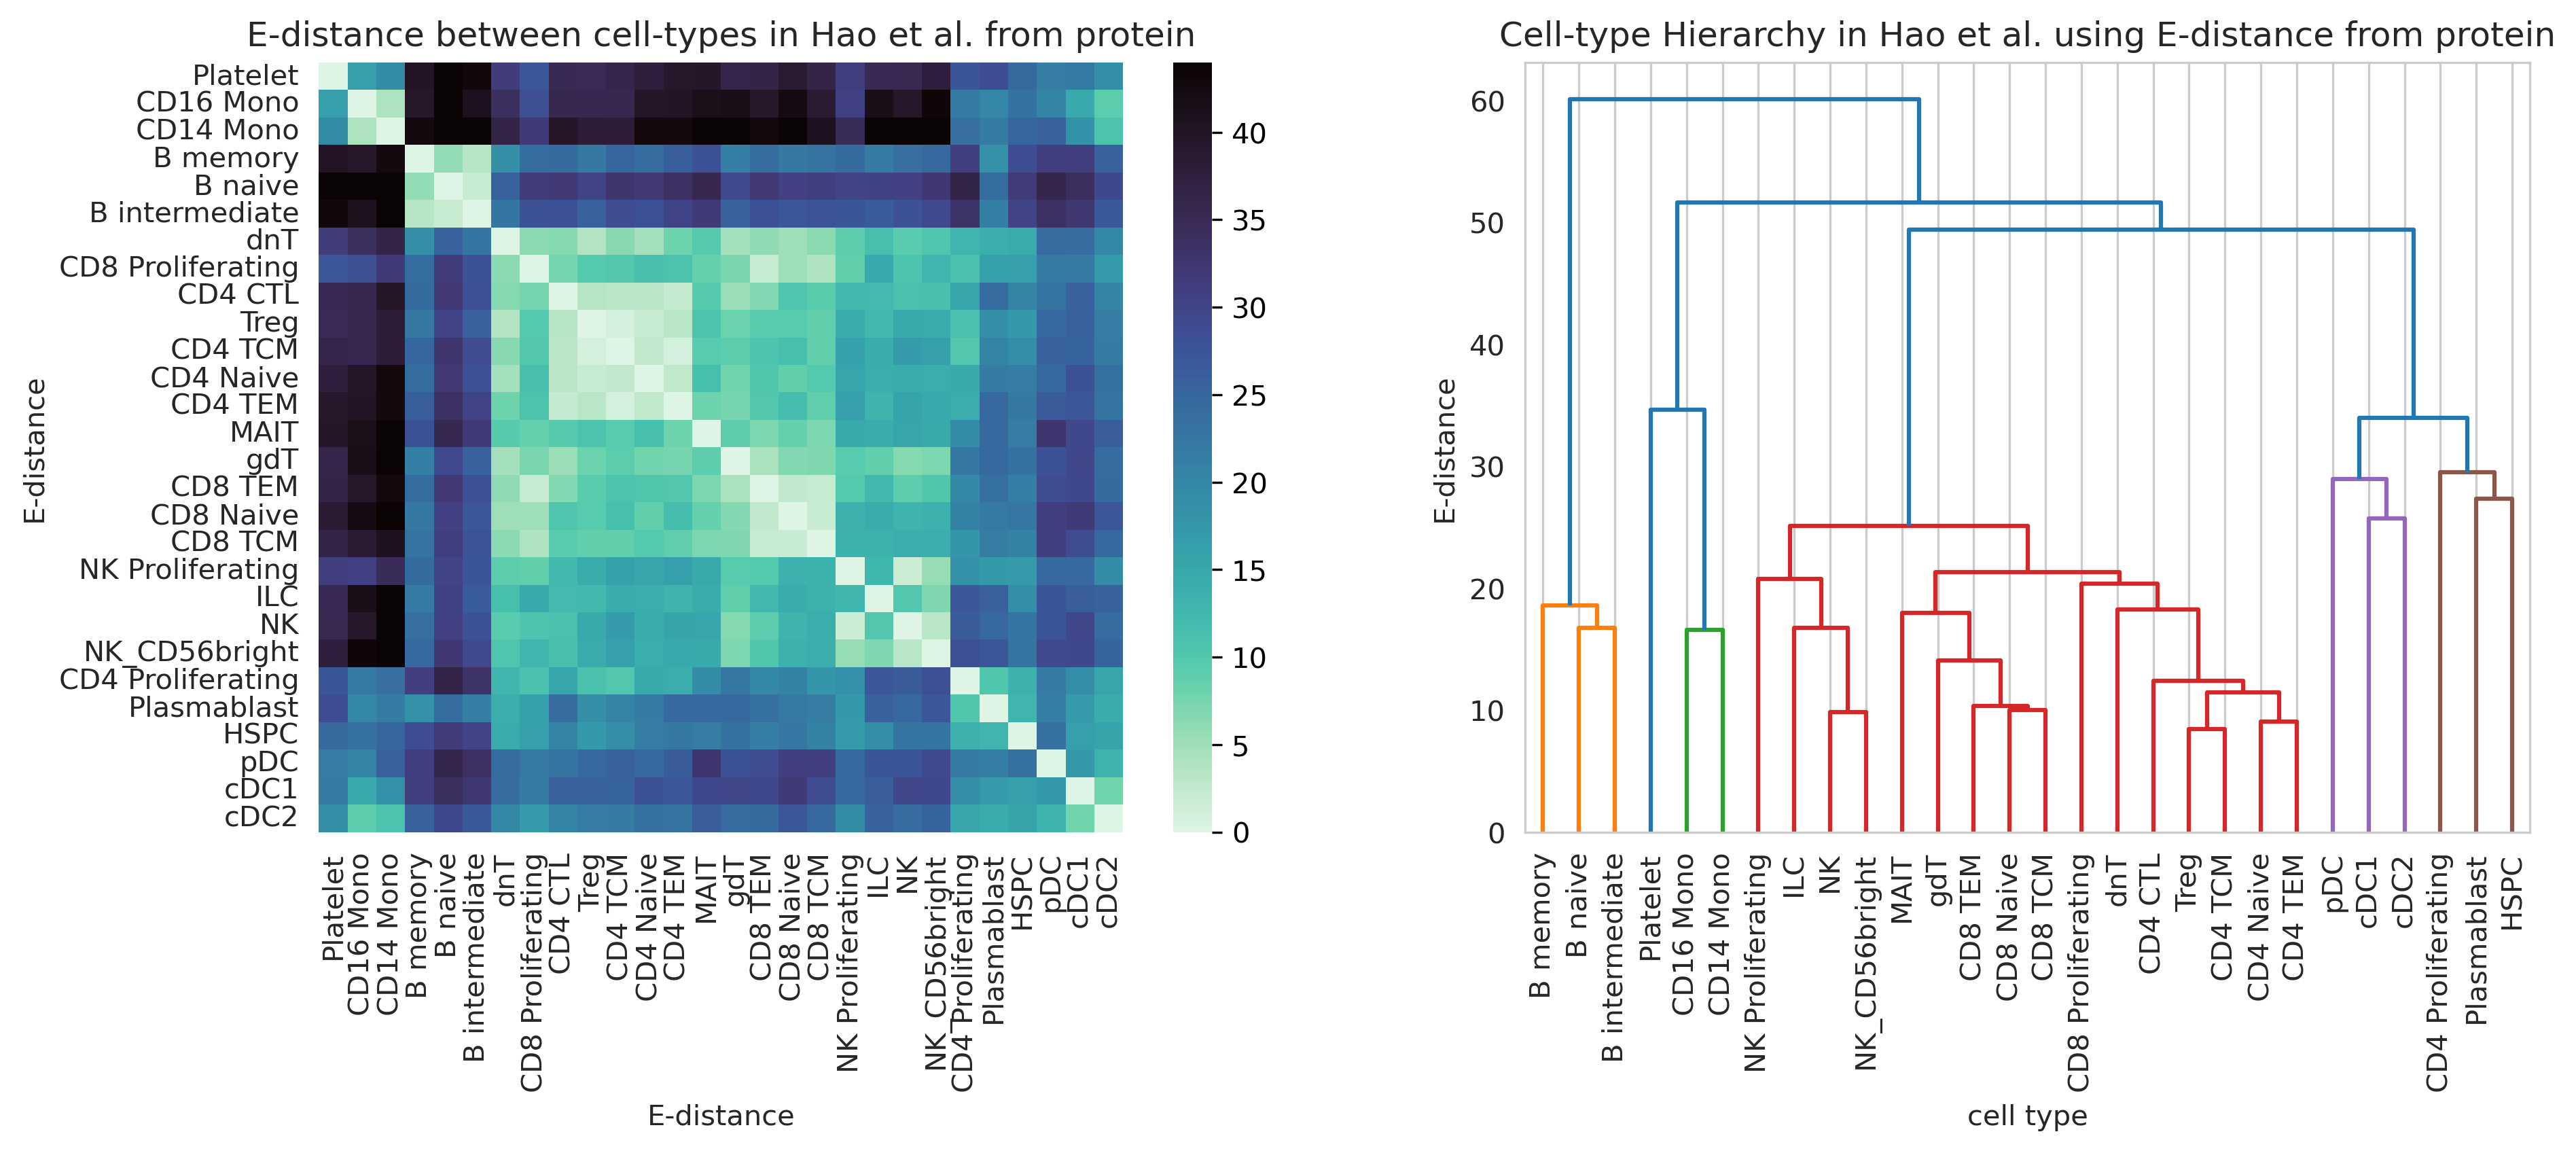

In [64]:
ed=estats_prot

with sns.axes_style('whitegrid'):
    fig, axs = plt.subplots(1, 2, figsize=[7*2,5])

ax = axs[0]
sns.heatmap(cluster_matrix(ed, "both"), robust=True, cmap = sns.cm.mako_r, xticklabels=True, yticklabels=True, ax=ax)
ax.set_title('E-distance between cell-types in Hao et al. from protein')
ax.set_xlabel('E-distance')
ax.set_ylabel('E-distance')

ax=axs[1]
Z = hierarchy.linkage(ed, 'single')
dn = hierarchy.dendrogram(Z, labels=ed.columns, color_threshold=30, ax=ax)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.ylabel('E-distance')
plt.xlabel('cell type')
plt.title('Cell-type Hierarchy in Hao et al. using E-distance from protein')
#plt.show()
plt.savefig("pbmc_protein_HaoHao.pdf", bbox_inches="tight")

In [48]:
adata.obsm['RNA_PCA']  = adata.obsm["X_pca"]# PCA of the RNA modality
adata.obsm['ADT_PCA'] = protein.obsm["X_pca"]

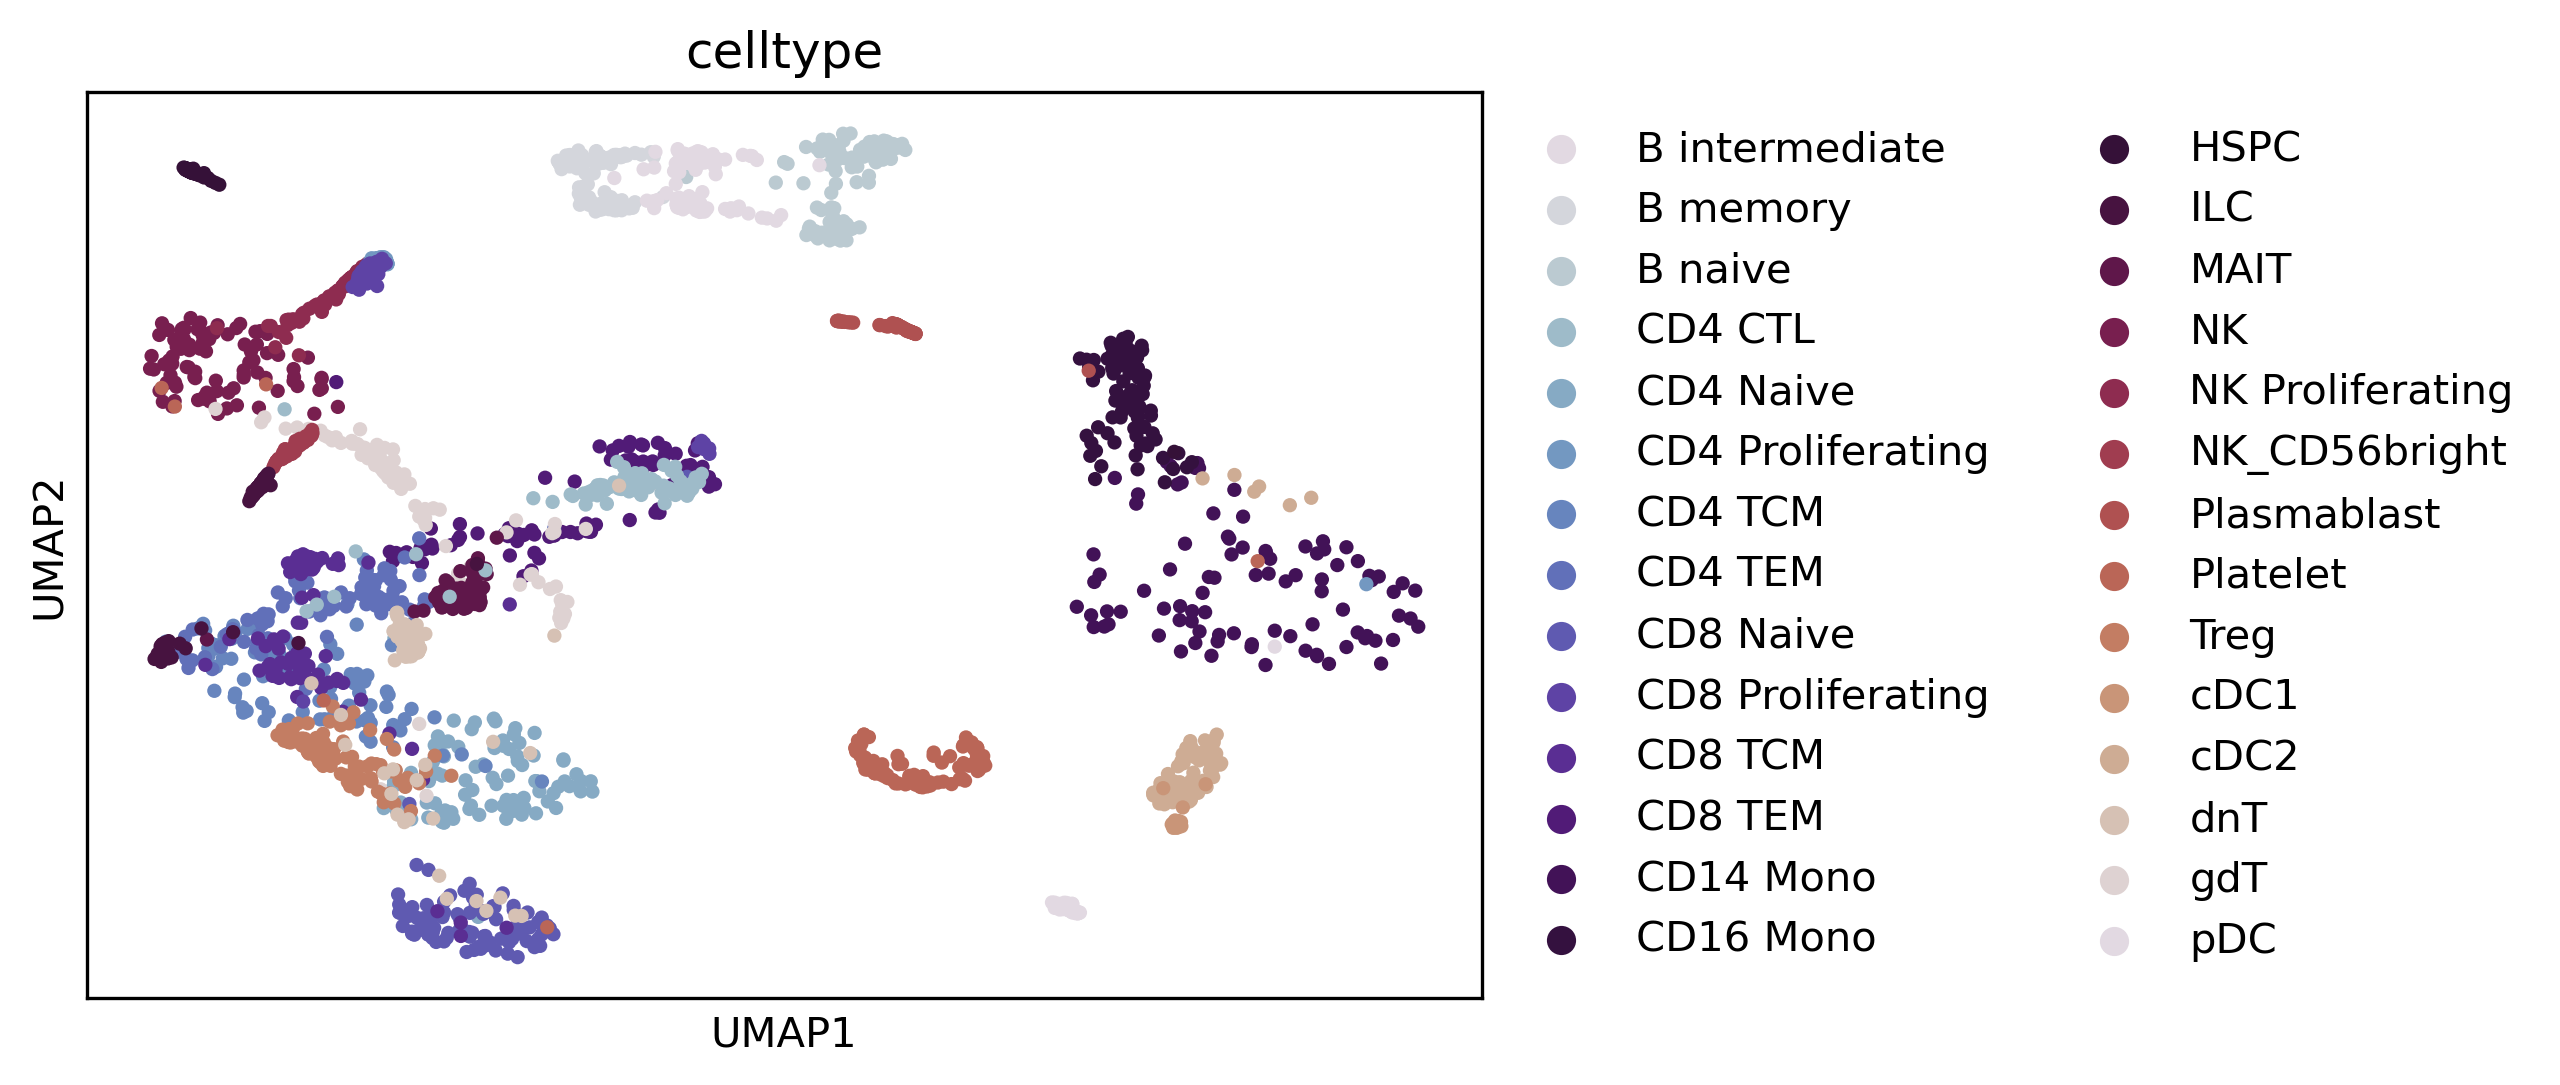

In [60]:
sc.pl.umap(adata, color="celltype", palette = "twilight", save = "_subset")

In [57]:
estats_rna

celltype,CD14 Mono,CD4 Naive,NK,CD4 TCM,CD8 TEM,CD8 Naive,B naive,CD16 Mono,CD4 TEM,gdT,...,NK_CD56bright,pDC,NK Proliferating,Plasmablast,dnT,HSPC,cDC1,ILC,CD4 Proliferating,CD8 Proliferating
celltype,,,,,,,,,,,,,,,,,,,,,
CD14 Mono,0.000000,904.723199,878.897868,822.749108,826.592024,911.264192,876.069945,272.183870,821.100354,833.489158,...,842.809340,987.176962,1050.527516,1256.587629,847.418022,891.455566,800.950618,736.969199,1189.999991,1055.096360
CD4 Naive,904.723199,0.000000,383.155099,35.287173,198.312979,7.319464,326.989047,817.107309,70.484601,191.914354,...,286.832004,700.552132,484.925216,508.826556,53.354412,272.420072,745.014738,152.443915,454.521299,392.483050
NK,878.897868,383.155099,0.000000,321.621175,103.226212,380.436922,586.989614,782.718030,275.371026,82.544287,...,120.531012,803.284524,168.464520,771.977443,321.335572,552.789438,890.018682,284.907260,657.087572,287.698741
CD4 TCM,822.749108,35.287173,321.621175,0.000000,137.194054,50.960691,341.657311,746.815065,16.692734,136.644458,...,249.243728,685.229247,433.877690,522.872896,54.865842,311.339809,731.538983,96.143176,413.194316,331.402074
CD8 TEM,826.592024,198.312979,103.226212,137.194054,0.000000,189.900221,445.074101,747.710325,97.102461,17.062378,...,152.382282,746.361352,250.150437,645.759699,136.062678,432.000998,775.304965,194.955855,481.583004,188.775109
CD8 Naive,911.264192,7.319464,380.436922,50.960691,189.900221,0.000000,331.825524,821.872672,83.737935,187.343095,...,283.918232,702.074507,481.734879,502.956373,53.831449,270.728732,744.500973,166.413211,460.947307,378.414687
B naive,876.069945,326.989047,586.989614,341.657311,445.074101,331.825524,0.000000,774.580930,358.682345,437.295192,...,473.067136,594.271383,708.723136,560.114864,336.453342,401.371414,617.216302,369.751229,767.332775,665.821635
CD16 Mono,272.183870,817.107309,782.718030,746.815065,747.710325,821.872672,774.580930,0.000000,755.952270,752.671462,...,778.805313,924.594494,931.845703,1175.825716,757.026927,828.191541,726.699327,674.754094,1072.160988,943.871240
CD4 TEM,821.100354,70.484601,275.371026,16.692734,97.102461,83.737935,358.682345,755.952270,0.000000,96.274840,...,218.277660,706.333524,403.231298,555.104632,66.200518,344.067873,756.269992,96.675141,437.405758,307.234069


In [59]:
# make a vecotr of the correlation between each entry in estats and estats_rna
corr_vec = np.zeros(len(estats))
for i in range(len(estats)):
    corr_vec[i] = estats[i].corrwith(estats_rna, axis=1).mean()

In [60]:
corr_vec

array([0.96629588, 0.956725  , 0.95340772, 0.95959081, 0.96619331,
       0.96625405, 0.96926425, 0.95470963])

<Axes: >

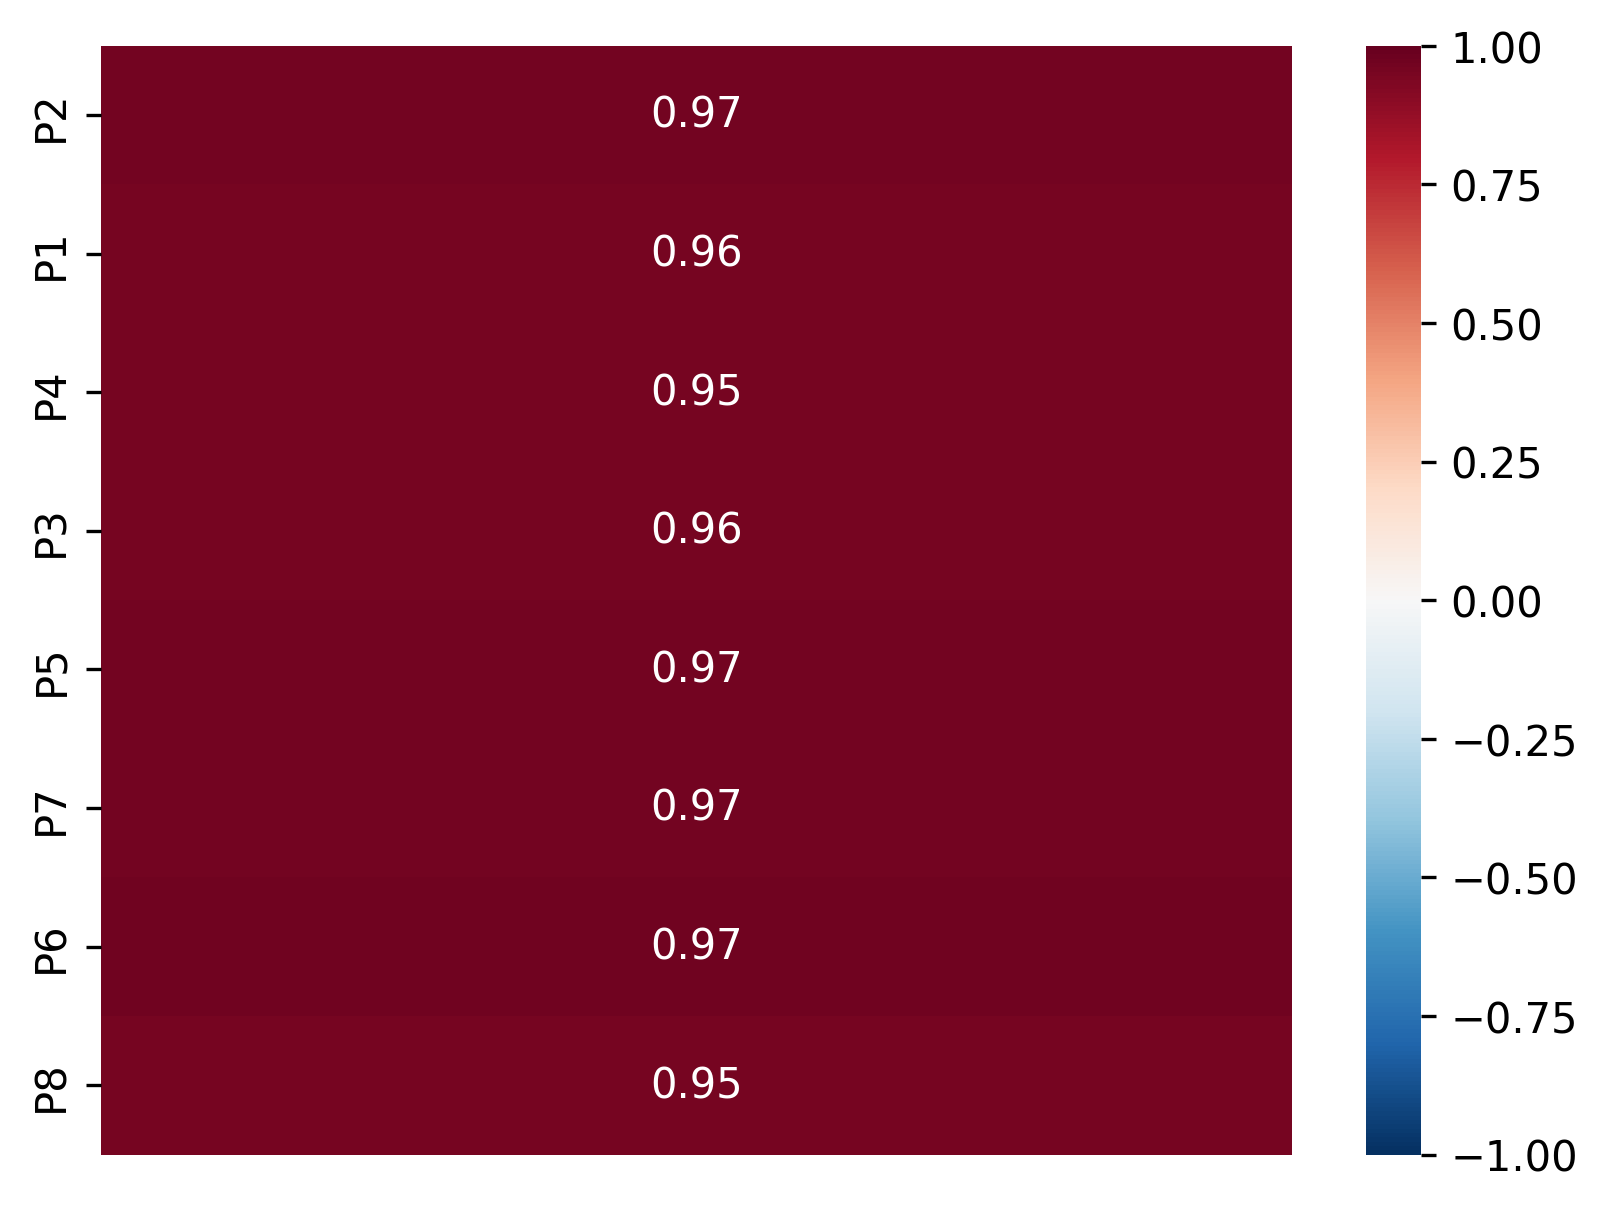

In [67]:
# plot corr_vec like a heatmap, but make it vertical and narrow
sns.heatmap(corr_vec.reshape(-1,1), annot=True, cmap='RdBu_r', vmin=-1, vmax=1, xticklabels=False, yticklabels=donors)


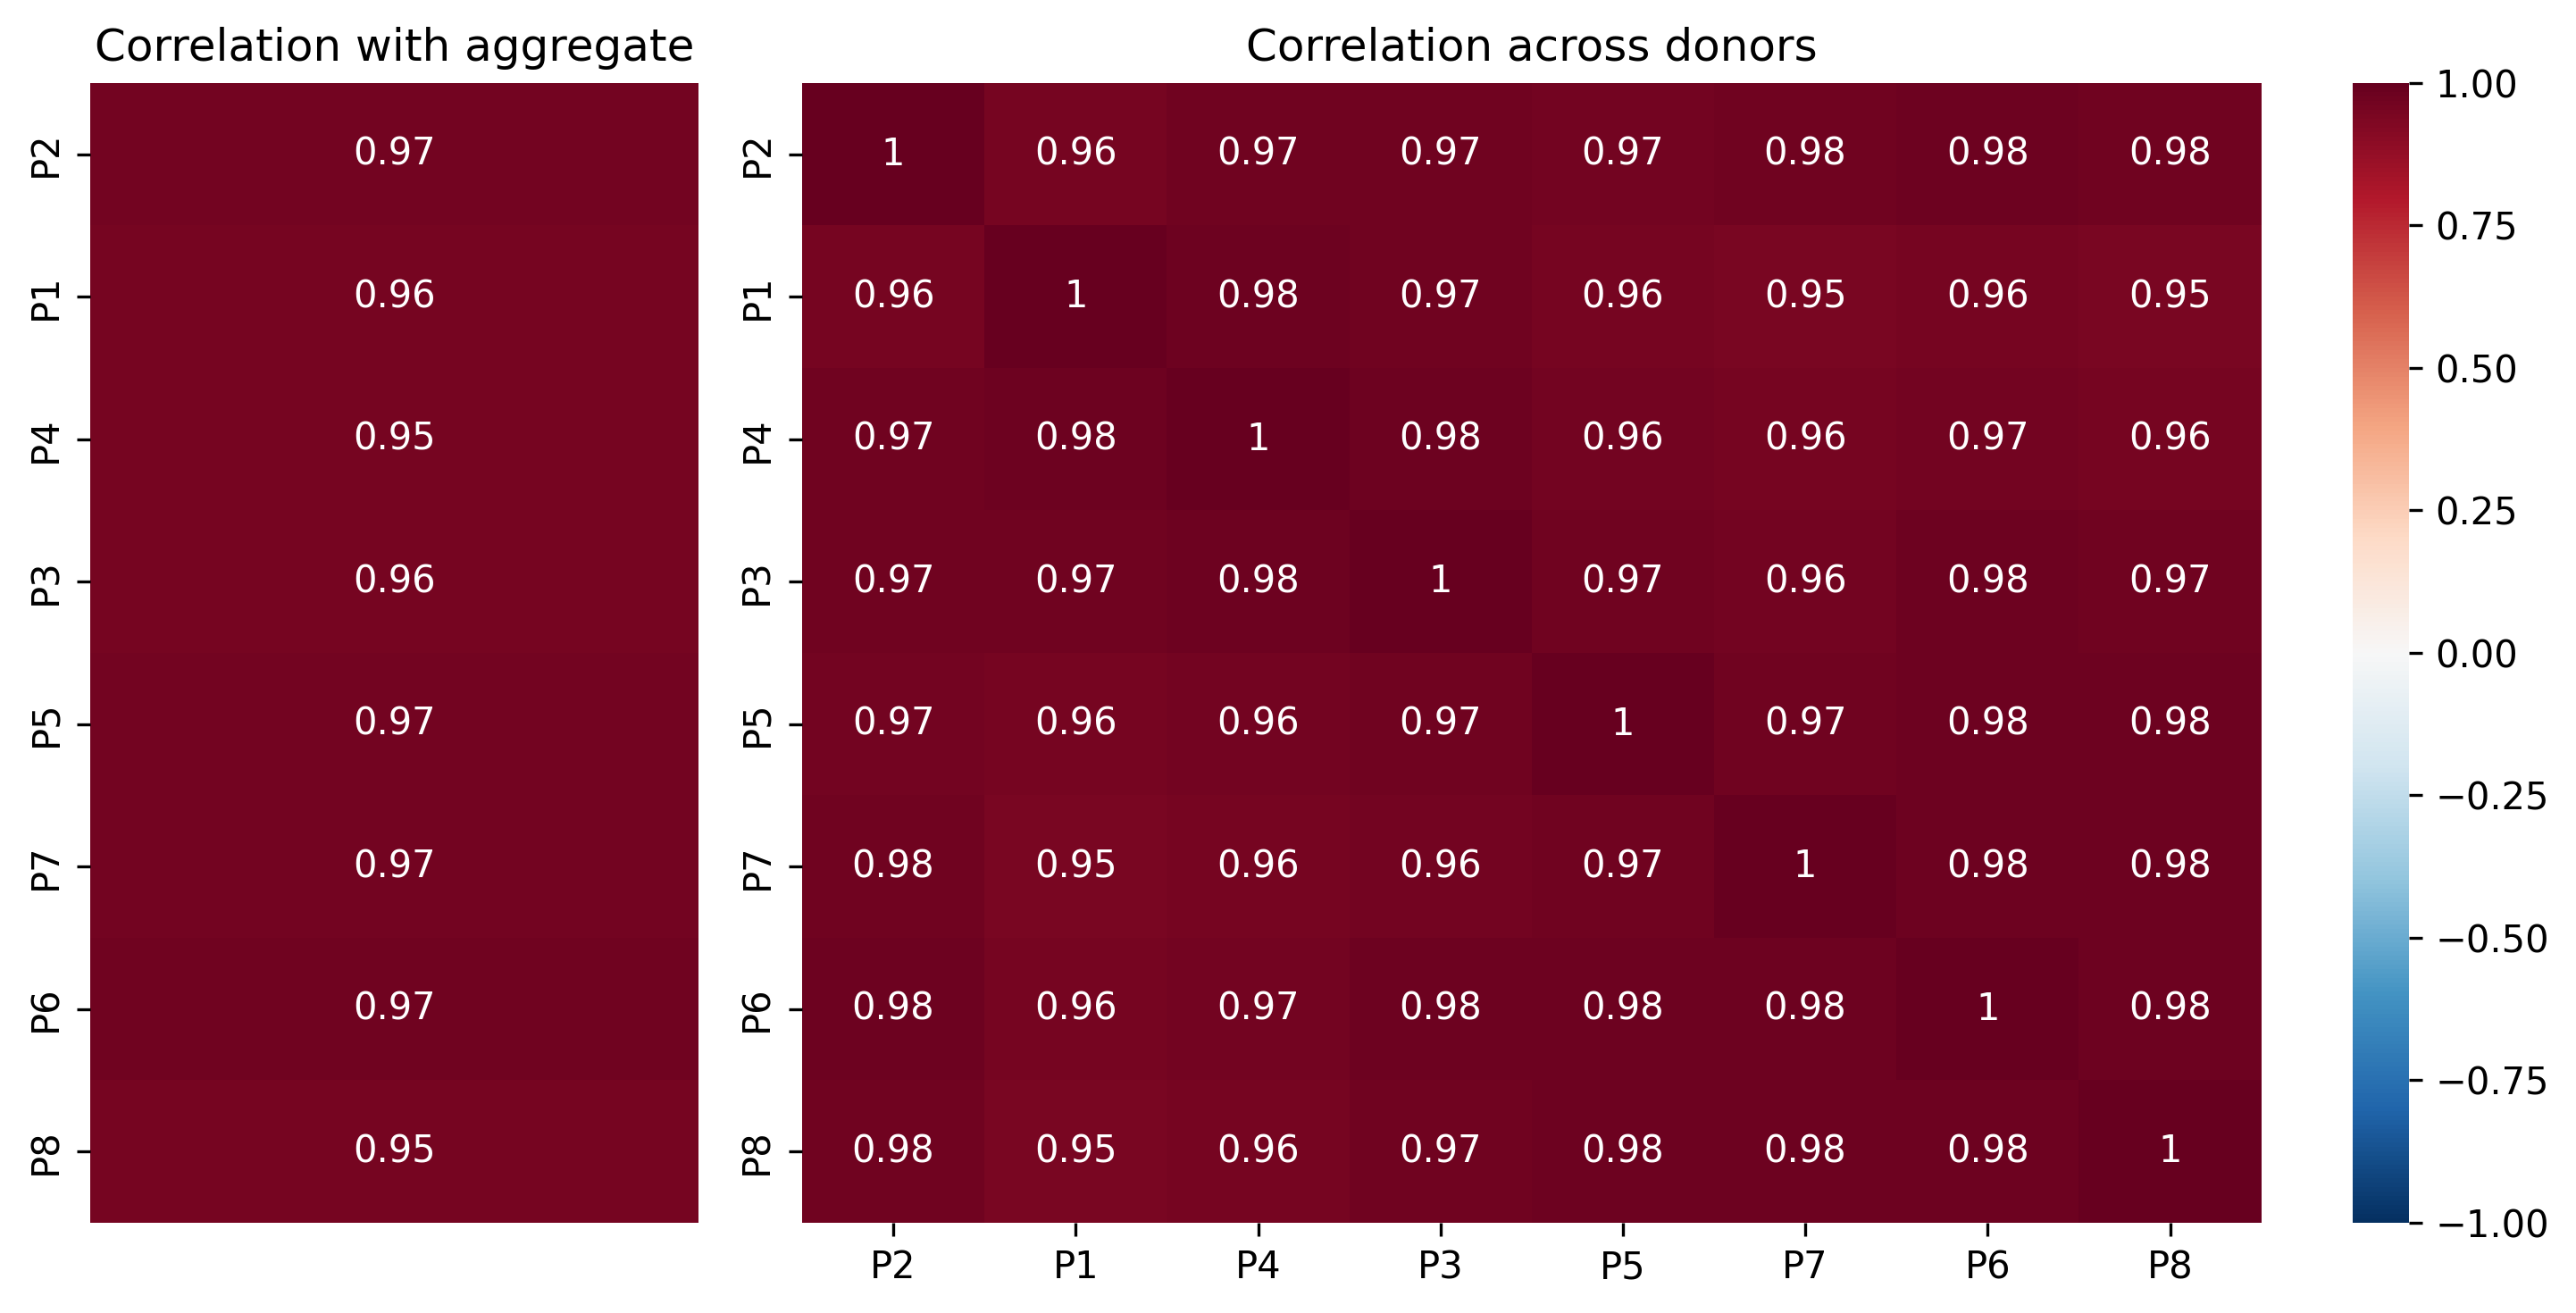

In [ ]:
# Create a figure with subplots and adjust width ratios
fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 3]})

# Plot the first heatmap in the first subplot without a color bar
sns.heatmap(corr_vec.reshape(-1, 1), annot=True, cmap='RdBu_r', vmin=-1, vmax=1, cbar=False, xticklabels=False, yticklabels=donors, ax=axes[0])
axes[0].set_title("Correlation with aggregate")

# Plot the second heatmap in the second subplot
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', vmin=-1, vmax=1, xticklabels=donors, yticklabels=donors, ax=axes[1])
axes[1].set_title("Correlation across donors")

# Adjust the layout
plt.tight_layout()

# Show the plots
#plt.show()
plt.savefig("figures/pbmc_correlation.pdf", bbox_inches="tight")

In [20]:
used_cells = pd.read_csv("/Users/tessa/Dropbox (HMS)/perturb_resource_tessa/notebooks/subset_cells_used.csv", index_col=0)

In [23]:
used_cells.index = used_cells.index.astype('str')

Text(0.5, 1.0, 'Distribution of cells by donor in the subset used for analysis')

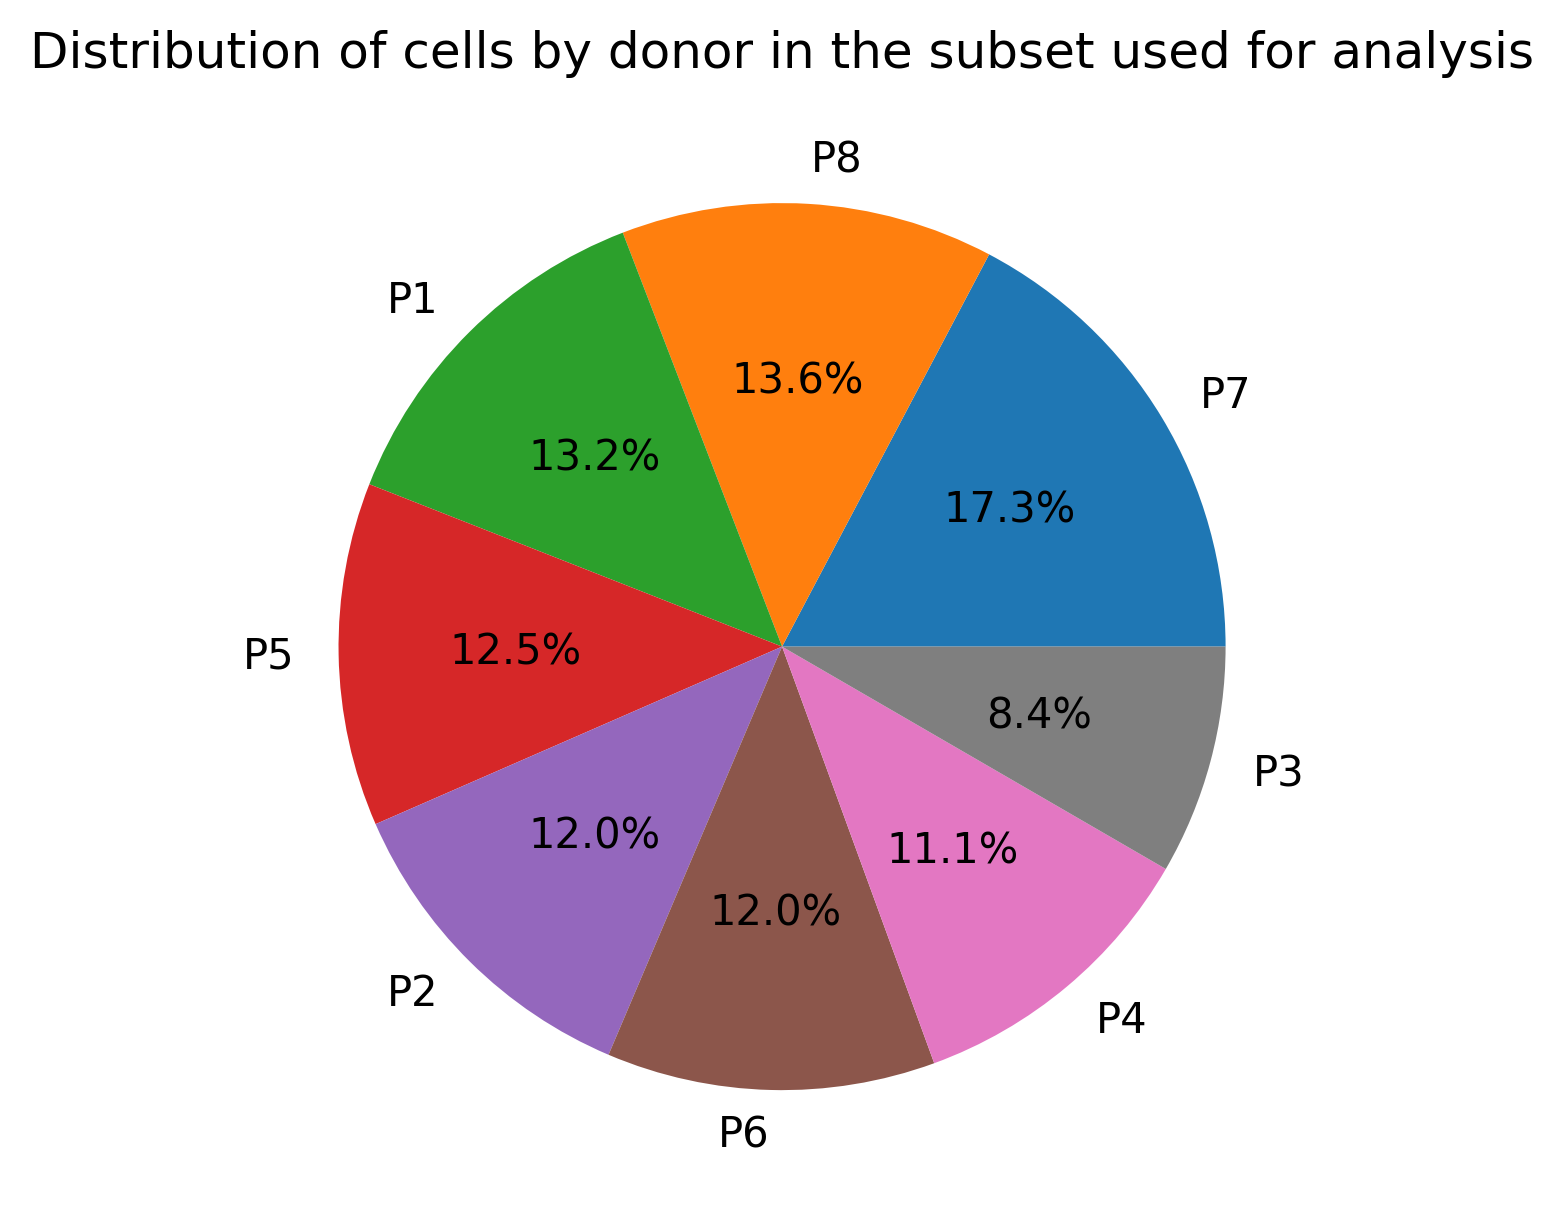

In [27]:
# plot a pie chart of used_cells["donor"]
plt.pie(used_cells["donor"].value_counts(), labels=used_cells["donor"].value_counts().index, autopct='%1.1f%%')
plt.title("Distribution of cells by donor in the subset used for analysis")